### Augment Data

#### Child Alone Category Simulated Entries  
> What is a functional 'child alone' message?  
> https://www.safewise.com/blog/what-to-do-when-your-child-goes-missing/

In [1]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline
import re
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from itertools import chain
import pickle
import augmenter

#### Pipeline Portion

In [2]:
# load messages dataset
df_mess = pd.read_csv('messages.csv')

# load categories dataset
df_cat = pd.read_csv('categories.csv')

# merge datasets
df = df_mess[['id','message']].merge(df_cat, left_on='id', right_on='id')

# determine list of categories
row = df_cat.categories[0]
category_colnames = [s[:-2] for s in row.split(';')]

# build dataframe of categorys with integer values
df_form = pd.DataFrame()
for i, nrow in df.iterrows():
    df_form[nrow['id']] = [int(s[-1]) for s in df.categories[i].split(';')]
df_form = df_form.transpose().reset_index().rename(columns={'index':'id'})
df_form.columns = ['id'] + category_colnames

# drop the original categories column from `df`
df = df.merge(df_form, left_on='id', right_on='id')
df = df.drop(['categories'], axis=1)

# target names
t_cols = df.columns[2:].tolist()

# split off validation data
# start with some zero's
dfv = df[df['related']==0].sample(36).copy()
idx_list = dfv.index.tolist()
# add in some one's for each target category
for cat in t_cols:
    # manage child alone has no entries
    if cat != 'child_alone':
        df_slice = df[df[cat]==1].copy()
        samp = df_slice.sample()
        while samp.index[0] in dfv.index:
            samp = df_slice.sample() 
        dfv = pd.concat([dfv, samp], axis=0)
    else:
        pass
    
# independant train and test data 
dft = df[~df.index.isin(dfv.index)].copy()

#### Augmentation Portion

In [3]:
# build 'child alone' messages
df_aug = augmenter.BuildCAs(dft)

# sample a 'child alone' entry for validation
samp = df_aug.sample()
dfv = pd.concat([dfv, samp], axis=0)

# build low count category messages
dfa = augmenter.BuildSims(df_aug, dft)

# combine original and augmented dataframes
df_all = pd.concat([df, dfa], axis = 0, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)

#### Before Augmentation

number of targets =  36


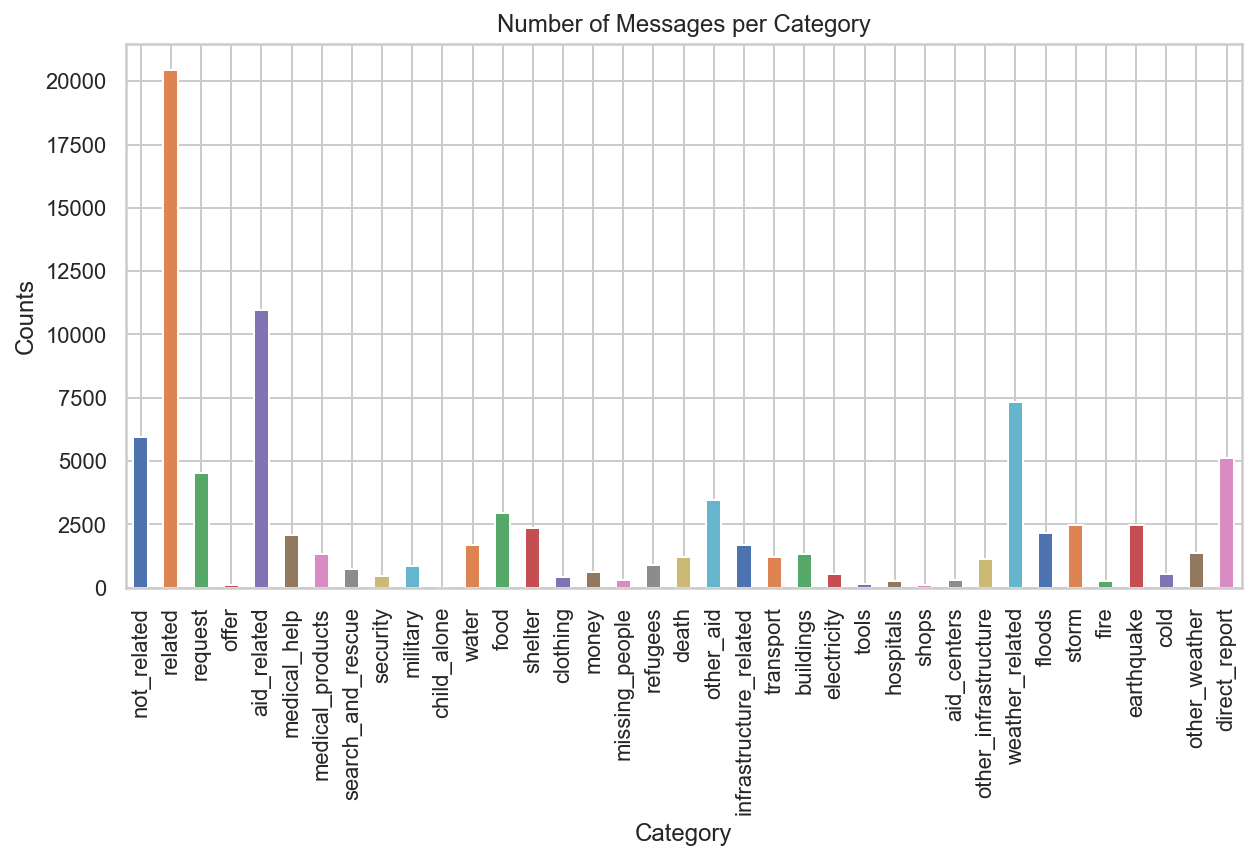

In [4]:
# target names
t_cols = df.columns[2:].tolist()
print('number of targets = ', len(t_cols))

# visualize breakdown of classes
counts = []
counts.append(('not_related',(len(df)-df['related'].sum())))
for t in t_cols:
    counts.append((t, df[t].sum()))
df_before = pd.DataFrame(counts, columns = ['category', 'counts'])
# plot
df_before.plot(x='category',y='counts',kind='bar',
               legend=False, grid=True, figsize=(10,5),
               color=sns.color_palette())
plt.title('Number of Messages per Category')
plt.ylabel('Counts')
plt.xlabel('Category')
plt.show();

In [5]:
# reveal count stats
df_before.describe()

,counts
count,37.000000
mean,2428.216216
std,3807.984296
min,0.000000
25%,471.000000
50%,1210.000000
75%,2461.000000
max,20442.000000


#### After Augmentation

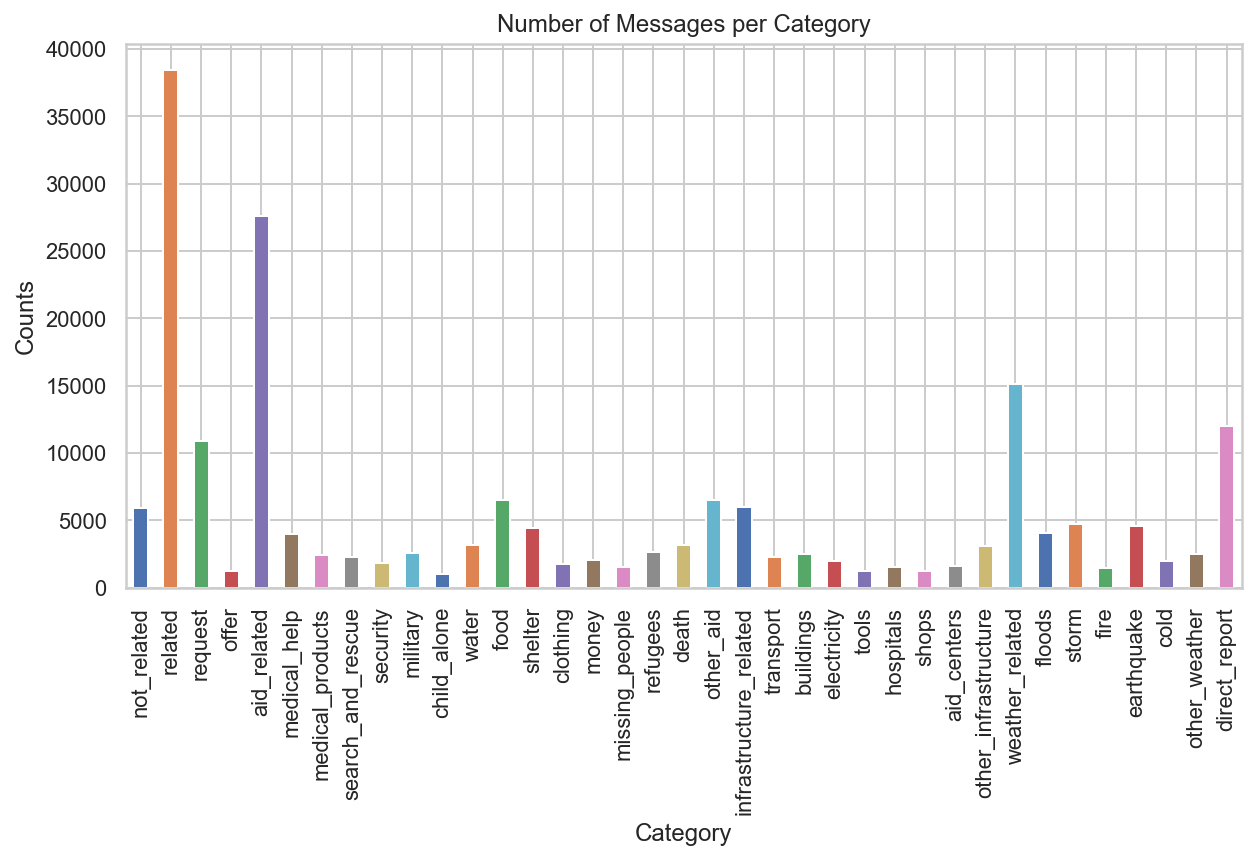

In [6]:
# visualize breakdown of classes
counts = []
counts.append(('not_related',(len(df_all)-df_all['related'].sum())))
for t in t_cols:
    counts.append((t, df_all[t].sum()))
df_after = pd.DataFrame(counts, columns = ['category', 'counts'])
# plot
df_after.plot(x='category',y='counts',kind='bar',
              legend=False, grid=True, figsize=(10,5),
              color=sns.color_palette())
plt.title('Number of Messages per Category')
plt.ylabel('Counts')
plt.xlabel('Category')
plt.show();

In [7]:
# reveal count stats
df_after.describe()

,counts
count,37.000000
mean,5352.729730
std,7505.938407
min,1000.000000
25%,1847.000000
50%,2550.000000
75%,4697.000000
max,38442.000000


#### Save Results

In [8]:
# save the validation set for later
dfv.to_csv('val_data_r5.csv', index=False)

# save augmentation set
dfa.to_csv('aug_data_r5.csv', index=False)

# save full set with simulated entries
df_all.to_csv('sim_data_r5.csv', index=False)